In [ ]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import matplotlib.pyplot as plt
from datasets import load_dataset
import optax
import time
import numpy as np
from functools import partial

# Helper functions for data loading and preprocessing
cache_dir="~/.cache/huggingface/datasets"

def load_mnist_data():
    """Load and preprocess MNIST dataset using Hugging Face datasets with JAX format."""
    print("Loading MNIST dataset from Hugging Face with JAX format...")
    
    # Load dataset from Hugging Face with JAX format
    mnist_dataset = load_dataset("mnist", cache_dir=cache_dir).with_format("jax")
    
    # Extract train and test sets directly as JAX arrays
    train_data = mnist_dataset["train"]
    test_data = mnist_dataset["test"]
    
    # Extract images and reshape to 28x28
    x_train = jnp.array([img.reshape(28, 28) for img in train_data["image"]])
    y_train = jnp.array(train_data["label"])
    
    x_test = jnp.array([img.reshape(28, 28) for img in test_data["image"]])
    y_test = jnp.array(test_data["label"])
    
    # Normalize data
    x_train = x_train.astype(jnp.float32) / 255.0
    x_test = x_test.astype(jnp.float32) / 255.0
    
    # Convert labels to one-hot encoding
    y_train = one_hot(y_train, 10)
    y_test = one_hot(y_test, 10)
    
    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)
    print("x_test shape:", x_test.shape)
    print("y_test shape:", y_test.shape)
    
    return x_train, y_train, x_test, y_test


# Load data
x_train, y_train, x_test, y_test = load_mnist_data()

def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

def get_batch(key, x, y, batch_size):
    """Get a random batch from the dataset."""
    dataset_size = x.shape[0]
    key, subkey = random.split(key)
    indices = random.choice(subkey, dataset_size, (batch_size,), replace=False)
    return x[indices], y[indices], key

# Common utility functions
def softmax(x):
    """Compute softmax values for each set of scores in x."""
    # Add more aggressive clipping for numerical stability
    shifted = x - jnp.max(x, axis=1, keepdims=True)
    exp_x = jnp.exp(jnp.clip(shifted, -30.0, 30.0))
    return exp_x / (jnp.sum(exp_x, axis=1, keepdims=True) + 1e-10)

def rmsnorm(x, gamma):
    """Root Mean Square Layer Normalization"""
    epsilon = 1e-5  # Increased epsilon for stability
    x_square = jnp.square(x)
    mean_square = jnp.mean(x_square, axis=-1, keepdims=True)
    # Add clipping to prevent division by very small numbers
    denom = jnp.maximum(jnp.sqrt(mean_square + epsilon), epsilon)
    x = x / denom
    return x * gamma

# Loss and metrics functions
def loss_fn(params, forward_fn, x_batch, y_batch):
    """Compute cross-entropy loss for given params and forward function."""
    logits = forward_fn(params, x_batch)
    
    # Clip logits for stability
    logits = jnp.clip(logits, -30.0, 30.0)
    
    # Use more stable log_softmax approach
    log_softmax = logits - jax.nn.logsumexp(logits, axis=1, keepdims=True)
    return -jnp.mean(jnp.sum(y_batch * log_softmax, axis=1))

def accuracy_fn(params, forward_fn, x_batch, y_batch):
    """Compute accuracy for given params and forward function."""
    logits = forward_fn(params, x_batch)
    pred_class = jnp.argmax(logits, axis=1)
    true_class = jnp.argmax(y_batch, axis=1)
    return jnp.mean(pred_class == true_class)

# Core evaluation function
def evaluate_model(init_params_fn, forward_fn, epochs=5, batch_size=64, learning_rate=0.001):
    """
    Evaluate an RNN architecture defined by init_params_fn and forward_fn.
    
    Args:
        init_params_fn: Function that initializes model parameters
        forward_fn: Function that performs forward pass on a batch of data
        epochs: Number of training epochs
        batch_size: Training batch size
        learning_rate: Learning rate for optimizer
        
    Returns:
        trained_params: The trained model parameters
        metrics: Dictionary containing training history and evaluation metrics
    """
    
    # x_train, y_train, x_test, y_test = load_mnist_data()
    # Get PRNGKey for reproducibility
    key = random.PRNGKey(42)
    
    # Initialize parameters
    print("Initializing model parameters...")
    params = init_params_fn(key)
    
    # Create optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    # Create vectorized forward function over batches
    batch_forward = jit(vmap(forward_fn, in_axes=(None, 0)))
    
    # Define update step
    @jit
    def update_step(params, opt_state, x_batch, y_batch):
        """Perform a single update step."""
        # Correctly define the loss function using the batch_forward function
        def batch_loss(p):
            return loss_fn(p, batch_forward, x_batch, y_batch)
            
        loss_value, grads = jax.value_and_grad(batch_loss)(params)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_opt_state, loss_value
    
    # Training loop
    print(f"Starting training for {epochs} epochs...")
    start_time = time.time()
    
    train_losses = []
    train_accs = []
    val_accs = []
    
    # Use a smaller validation set
    val_size = 1000
    val_x = x_test[:val_size]
    val_y = y_test[:val_size]
    
    for epoch in range(epochs):
        epoch_losses = []
        
        # Number of batches per epoch
        num_batches = x_train.shape[0] // batch_size
        
        for batch in range(num_batches):
            # Get batch
            batch_x, batch_y, key = get_batch(key, x_train, y_train, batch_size)
            
            # Update parameters
            params, opt_state, loss_value = update_step(params, opt_state, batch_x, batch_y)
            epoch_losses.append(loss_value)
            
            # Print progress occasionally
            if batch % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch}/{num_batches}, Loss: {loss_value:.4f}")
        
        # Compute epoch metrics
        avg_loss = jnp.mean(jnp.array(epoch_losses))
        train_losses.append(float(avg_loss))
        
        # Compute validation accuracy
        val_acc = accuracy_fn(params, batch_forward, val_x, val_y)
        val_accs.append(float(val_acc))
        
        print(f"Epoch {epoch+1}/{epochs} completed. Avg Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    
    # Compute final test accuracy
    test_acc = accuracy_fn(params, batch_forward, x_test, y_test)
    print(f"Final test accuracy: {test_acc:.4f}")
    
    # Compute training time
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds.")
    
    # Visualize only incorrect predictions
    def plot_wrong_predictions(max_examples=10):
        """Plot only the examples where the model makes mistakes."""
        # Get predictions for the test set
        logits = batch_forward(params, x_test)
        pred_labels = jnp.argmax(logits, axis=1)
        true_labels = jnp.argmax(y_test, axis=1)
        
        # Find indices where predictions are wrong
        wrong_indices = jnp.where(pred_labels != true_labels)[0]
        
        if len(wrong_indices) == 0:
            print("No wrong predictions found in the test set!")
            return
            
        # Limit the number of examples to display
        num_examples = min(max_examples, len(wrong_indices))
        selected_indices = wrong_indices[:num_examples]
        
        # Plot the incorrect predictions
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(selected_indices):
            plt.subplot(1, num_examples, i + 1)
            plt.imshow(np.array(x_test[idx]), cmap='gray')
            plt.title(f"True: {int(true_labels[idx])}\nPred: {int(pred_labels[idx])}")
            plt.axis('off')
        plt.tight_layout()
        plt.suptitle("Incorrect Predictions", fontsize=16)
        plt.subplots_adjust(top=0.8)
        plt.show()
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accs)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()
    
    # Show incorrect predictions
    plot_wrong_predictions()
    
    # Return the trained parameters and metrics
    metrics = {
        'train_losses': train_losses,
        'val_accs': val_accs,
        'test_acc': float(test_acc),
        'training_time': training_time
    }
    
    return params, metrics
    

/home/cwhy/Projects/Jax/picojam/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Two-Layer Diagonal RNN with SwiGLU Testing
------------------------------------------
Loading MNIST dataset from Hugging Face with JAX format...
x_train shape: (60000, 28, 28)
y_train shape: (60000, 10)
x_test shape: (10000, 28, 28)
y_test shape: (10000, 10)
Initializing model parameters...
Starting training for 40 epochs...
Epoch 1/40, Batch 0/937, Loss: 2.3026
Epoch 1/40, Batch 100/937, Loss: 2.3030
Epoch 1/40, Batch 200/937, Loss: 2.0633
Epoch 1/40, Batch 300/937, Loss: 1.9760
Epoch 1/40, Batch 400/937, Loss: 1.8202
Epoch 1/40, Batch 500/937, Loss: 1.4697
Epoch 1/40, Batch 600/937, Loss: 1.5425
Epoch 1/40, Batch 700/937, Loss: 1.2761
Epoch 1/40, Batch 800/937, Loss: 1.2779
Epoch 1/40, Batch 900/937, Loss: 1.3331
Epoch 1/40 completed. Avg Loss: 1.7026, Val Accuracy: 0.5020
Epoch 2/40, Batch 0/937, Loss: 1.3991
Epoch 2/40, Batch 100/937, Loss: 1.3348
Epoch 2/40, Batch 200/937, Loss: 1.3879
Epoch 2/40, Batch 300/937, Loss: 1.4621
Epoch 2/40, Batch 400/937, Loss: 1.1774
Epoch 2/40, Batc

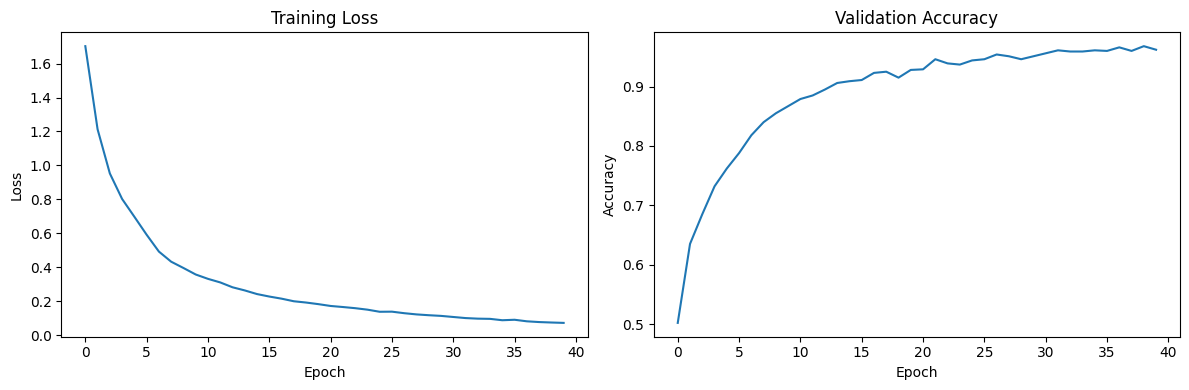

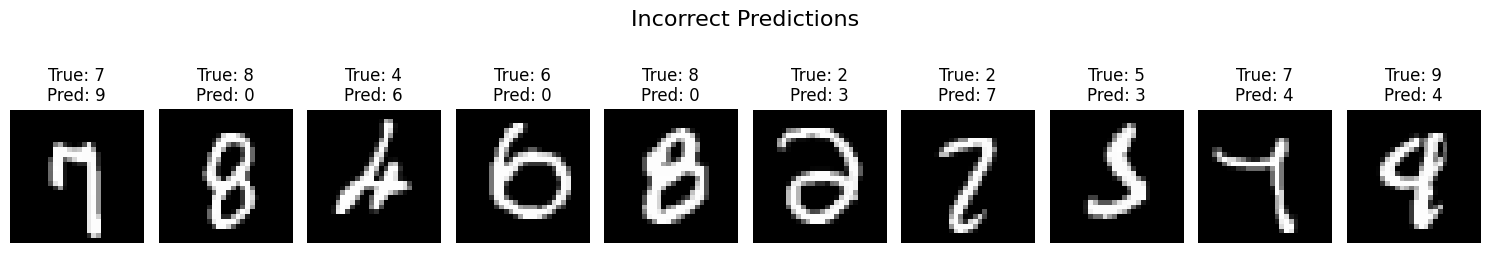

Evaluation complete!
Test accuracy: 0.9681
Training time: 52.09 seconds


In [ ]:
import jax
import jax.numpy as jnp
from jax import random, lax
import jax.nn as nn

def diagonal_init_params(key):
    """Initialize parameters for a 2-layer diagonal RNN with SwiGLU between layers."""
    hidden_size = 128
    features = 28   # MNIST image width
    num_classes = 10
    intermediate_size = 128  # Size for the SwiGLU intermediate representation
    
    # Initialization scale
    init_scale = 0.01
    
    k1, k2, k3, k4, k5 = random.split(key, 5)
    
    return {
        # First layer parameters
        'Wxh': random.normal(k1, (features, hidden_size)) * init_scale,
        
        # Shared diagonal weights for recurrent connections in both layers
        'diag_weights': random.normal(k2, (hidden_size,)) * init_scale,
        
        # SwiGLU parameters for layer-to-layer transition
        'W_gate': random.normal(k3, (hidden_size, intermediate_size)) * init_scale,
        'W_linear': random.normal(k4, (hidden_size, intermediate_size)) * init_scale,
        'W_out': random.normal(k5, (intermediate_size, hidden_size)) * init_scale,
        
        # Output layer
        'Wo': random.normal(k2, (hidden_size, num_classes)) * init_scale,
        'bo': jnp.zeros(num_classes)
    }

def swiglu(x, params):
    """
    SwiGLU activation: SwiGLU(x) = Swish(xW_gate) ⊗ (xW_linear)
    where Swish(x) = x * sigmoid(beta * x), with beta commonly set to 1.0
    """
    gate = x @ params['W_gate']
    linear = x @ params['W_linear']
    
    # Swish activation (x * sigmoid(x))
    swish = gate * nn.sigmoid(gate)
    
    # Element-wise product with linear projection
    intermediate = swish * linear
    
    # Final projection
    return intermediate @ params['W_out']

def two_layer_sequential_forward_fn(params, x_seq):
    """
    Sequential forward function for a 2-layer diagonal RNN with SwiGLU between layers.
    """
    hidden_size = params['diag_weights'].shape[0]
    
    # Initialize hidden states for both layers
    h1 = jnp.zeros(hidden_size)
    h2 = jnp.zeros(hidden_size)
    
    # Process each timestep
    for t in range(x_seq.shape[0]):
        # Layer 1
        input_proj = jnp.dot(x_seq[t], params['Wxh'])
        recurrent_proj = h1 * params['diag_weights']
        h1 = input_proj + recurrent_proj
        
        # Apply SwiGLU to h1 before feeding to layer 2
        h1_transformed = swiglu(h1, params)
        
        # Layer 2
        recurrent_proj = h2 * params['diag_weights']
        h2 = h1_transformed + recurrent_proj
        
    # Output layer using final hidden state from layer 2
    logits = jnp.dot(h2, params['Wo']) + params['bo']
    
    return logits

def two_layer_parallel_scan_forward_fn(params, x_seq):
    """
    Forward function for a 2-layer diagonal RNN using parallel scan with SwiGLU between layers.
    """
    hidden_size = params['diag_weights'].shape[0]
    diag_weights = params['diag_weights']
    
    # Define a single step function for layer 1
    def layer1_step(h, x):
        input_proj = jnp.dot(x, params['Wxh'])
        recurrent_proj = h * diag_weights
        h_new = input_proj + recurrent_proj
        return h_new, h_new
    
    # Process layer 1 with parallel scan
    init_state = jnp.zeros(hidden_size)
    _, layer1_hidden_states = lax.scan(
        f=layer1_step,
        init=init_state, 
        xs=x_seq
    )
    
    # Apply SwiGLU to all hidden states from layer 1
    # vmap allows us to apply the function to each element in the batch efficiently
    layer1_transformed = jax.vmap(lambda x: swiglu(x, params))(layer1_hidden_states)
    
    # Define a single step function for layer 2
    def layer2_step(h, x):
        # x is already transformed by SwiGLU
        recurrent_proj = h * diag_weights
        h_new = x + recurrent_proj
        return h_new, h_new
    
    # Process layer 2 with parallel scan, using SwiGLU-transformed layer1 output as input
    _, layer2_hidden_states = lax.scan(
        f=layer2_step,
        init=init_state,
        xs=layer1_transformed
    )
    
    # Use the final hidden state from layer 2 for the output
    final_h = layer2_hidden_states[-1]
    logits = jnp.dot(final_h, params['Wo']) + params['bo']
    
    return logits

def two_layer_fast_associative_scan_forward_fn(params, x_seq):
    """
    A fast implementation of a 2-layer diagonal RNN with SwiGLU between layers.
    Uses associative scan for maximum parallelism.
    """
    diag_weights = params['diag_weights']
    
    # Layer 1: Pre-compute all input projections
    layer1_input_projections = jnp.dot(x_seq, params['Wxh'])
    
    # Define the binary associative operator for layer 1
    def binary_operator(accumulated, new_input):
        return accumulated * diag_weights + new_input
    
    # Process layer 1 with associative scan
    layer1_hidden_states = lax.associative_scan(
        binary_operator,
        layer1_input_projections
    )
    
    # Apply SwiGLU to all hidden states from layer 1
    layer1_transformed = jax.vmap(lambda x: swiglu(x, params))(layer1_hidden_states)
    
    # Process layer 2 with associative scan
    layer2_hidden_states = lax.associative_scan(
        binary_operator,
        layer1_transformed
    )
    
    # Get the final hidden state from layer 2
    final_h = layer2_hidden_states[-1]
    
    # Output layer
    logits = jnp.dot(final_h, params['Wo']) + params['bo']
    
    return logits

def two_layer_fused_scan_forward_fn(params, x_seq):
    """
    A more efficient implementation that fuses both layers into a single scan.
    Uses SwiGLU for the layer-to-layer transformation.
    """
    hidden_size = params['diag_weights'].shape[0]
    diag_weights = params['diag_weights']
    
    # Define a function that processes both layers for a single timestep
    def two_layer_step(carry, x):
        h1, h2 = carry
        
        # Layer 1
        input_proj1 = jnp.dot(x, params['Wxh'])
        recurrent_proj1 = h1 * diag_weights
        h1_new = input_proj1 + recurrent_proj1
        
        # Apply SwiGLU to connect layer 1 to layer 2
        h1_transformed = swiglu(h1_new, params)
        
        # Layer 2
        recurrent_proj2 = h2 * diag_weights
        h2_new = h1_transformed + recurrent_proj2
        
        return (h1_new, h2_new), (h1_new, h2_new)
    
    # Initialize both hidden states
    init_states = (jnp.zeros(hidden_size), jnp.zeros(hidden_size))
    
    # Process the entire sequence with a single scan
    _, (layer1_states, layer2_states) = lax.scan(
        f=two_layer_step,
        init=init_states,
        xs=x_seq
    )
    
    # Use the final hidden state from layer 2 for the output
    final_h = layer2_states[-1]
    logits = jnp.dot(final_h, params['Wo']) + params['bo']
    
    return logits

# Example usage
if __name__ == "__main__":
    print("Two-Layer Diagonal RNN with SwiGLU Testing")
    print("------------------------------------------")
    
    # Choose one of the implementations:
    # 1. Standard sequential 2-layer RNN
    # forward_fn = two_layer_sequential_forward_fn
    
    # 2. Parallel scan for each layer separately
    # forward_fn = two_layer_parallel_scan_forward_fn
    
    # 3. Fast associative scan for each layer
    forward_fn = two_layer_fast_associative_scan_forward_fn
    
    # 4. Fused scan processing both layers together (likely fastest)
    # forward_fn = two_layer_fused_scan_forward_fn
    
    # Evaluate model
    trained_params, metrics = evaluate_model(
        init_params_fn=diagonal_init_params,
        forward_fn=forward_fn,
        epochs=40,
        batch_size=64,
        learning_rate=0.0005
    )
    
    print("Evaluation complete!")
    print(f"Test accuracy: {metrics['test_acc']:.4f}")
    print(f"Training time: {metrics['training_time']:.2f} seconds")